# Podstawy uczenia maszynowego - tutorial 2: Feature selection and extraction

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Przygotowanie zbiorów danych

In [14]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [ ]:
# Zbiór danych medycznych pacjentów pozwalający na diagnostykę raka płuc

cancer = datasets.load_breast_cancer()
cancer.data = scale(cancer.data)

In [ ]:
# zbiór danych pozwalający przewidywać, czy małżeństwo się rozpadnie na podstawie odpowiedzi (w skali 0-4) na 56 pytań

divorces = pd.read_csv('./datasets/divorce.csv', sep=';')

# treści pytań są przechowywane w osobnym pliku
with open('./datasets/questions.csv') as file:
    questions = np.array(file.read().split('\n'))

divorces = {
    'data': divorces.drop(labels=['Class'], axis=1).astype(float),
    'target': list(divorces['Class']),
    'feature_names': questions
}

divorces['data'] = scale(divorces['data'])

## Selekcja cech

Selekcja cech to ograniczenie liczby atrybutów danych, na których pracuje model, przez odrzucenie najmniej użytecznych z nich. Taka rezygnacja z części danych pozwala osiągnąć konkretne korzyści:
* redukcja wymiarów - odrzucenie części cech oznacza zmniejszenie wymiarowości problemu, co ułatwia uniknięcie przetrenowania modelu
* uproszczenie modelu - model pracujący na mniejszej liczbie cech jest bardziej zrozumiały i łatwiej identyfikować w nim problemy
* lepsze wyniki - cechy niezwiązane z badaną właściwością mogą w sposób losowy zaburzać otrzymywane wyniki
* poprawa wydajności - mało istotne cechy są przetwarzane niepotrzebnie

### Metody Selekcji cech

#### 1. Odrzucenie cech niecharakterystycznych

Cechy, które wykazują niewielką zmienność pomiędzy próbkami, prawdopodobnie nie niosą szczególnie użytecznej informacji - zazwyczaj nie można na ich podstawie dokonać klasyfikacji (choć warto zachować ostrożność przy zbiorach danych o silnej dysproporcji pomiędzy licznościami klas oraz cechach mogących przyjmować wartości z niewielkiego zakresu). Cechy takie można rozpoznać po niewielkiej wariancji - stąd najprostsze podejście do selekcji cech może polegać na ich przefiltrowaniu i odrzuceniu tych o zbyt niskiej wariancji.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# variance should equal, because ...

selector = VarianceThreshold()
cancer.data = selector.fit_transform(cancer.data)


# lista atrybutów wymaga zaktualizowania, selector.get_support() zwraca indeksy wybranych cech
cancer['feature_names'] = cancer['feature_names'][selector.get_support(indices=True)]

In [ ]:
selector = VarianceThreshold()
divorces['data'] = selector.fit_transform(divorces['data'])

divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 2. Odrzucenie cech niezwiązanych z badaną właściwością

Możemy spróbować przewidzieć, na ile każda z cech jest związana z badaną właściwością, i odrzucić te, dla których związek jest luźny. Możliwe są dwa zasadnicze podejścia:

##### 2.1. Obliczenie korelacji

Najprostszym sposobem określenia, czy cecha jest związana z inną (w szczególności - przynależnością do danej klasy) jest obliczenie korelacji między nimi.

In [ ]:
def filter_correlation(X, Y, feature_names, n_features):
    scores = [abs(np.corrcoef(feature, Y))[0, 1] for feature in X.T]
    selected_indices = np.argsort(scores)[:n_features]
    data = X.T[selected_indices].T
    selected_feature_names = feature_names[selected_indices]
    return data, selected_feature_names

In [ ]:
cancer.data, cancer.feature_names = filter_correlation(cancer.data, cancer.target, cancer.feature_names, 15)

In [ ]:
divorces['data'], divorces['feature_names'] = \
    filter_correlation(divorces['data'], divorces['target'], divorces['feature_names'], 40)

##### 2.2. Inne statystyki

Alternatywnie, możemy wykorzystać inną statystykę, której wartość rośnie wraz ze wzrostem różnicy wartości w dwóch grupach - np. Chi-kwadrat. 

W tym celu zakładamy, że badana cecha (nazwijmy ją A) nie ma związku z przynależnością próbki do określonej klasy (oznaczmy ją przez C). Opierając się na tym założeniu, obliczamy, ile próbek z każdą możliwą wartością cechy A powinno należeć do klasy C (jako liczba próbek o danej wartości cechy A * liczba próbek w ekperymencie należących do klasy C / liczba wszystkich próbek),
i obliczamy wartość wybranej statystyki na podstawie różnic pomiędzy otrzymanymi wartościami a rzeczywistymi danymi.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
selector = SelectKBest(chi2, k=20)

cancer.data = selector.fit_transform(cancer.data, cancer.target)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [ ]:
selector = SelectKBest(chi2, k=30)

divorces['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

#### 3. Próbne wytrenowanie modelu

##### 3.1. Odfiltrowanie cech nieznaczących

Zamiast "ręcznie" znajdować i usuwać mało istotne cechy, możemy spróbować wytrenować na naszych danych model, który ucząc się "przy okazji" zapisuje istotność cech, i usunąć te, które nie mają dużego znaczenia w podejmowaniu decyzji przez model. Aby zastosować takie podejści, konieczny jest wybór modelu, który udostępnia istotność cech - w przypadku Scikit-learn są to modele posiadające pole coef_ lub feature_importances_.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(cancer.data, cancer.target)
selector = SelectFromModel(classifier, prefit=True)

cancer.data = selector.transform(cancer.data)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [ ]:
classifier = ExtraTreesClassifier(n_estimators=50)

classifier = classifier.fit(divorces['data'], divorces['target'])
selector = SelectFromModel(classifier, prefit=True)

divorces['data'] = selector.transform(divorces['data'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

##### 3.2. Rekurencyjny wybór zadanej liczby najlepszych cech

Jeżeli chcemy ograniczyć liczbę cech do konkretnej wartości, powyższe podejście można zmodyfikować: zamiast wybierać cechy powyżej określonej granicy, lepszym podejściem może być odrzucenie najsłabszej z cech (lub kilku najgorszych) i rekurencyjne powtarzanie procesu, aż do osiągnięcia zadanej ich liczby.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 20, step=3)

cancer.data = selector.fit_transform(cancer.data, cancer.target)
cancer.feature_names = cancer.feature_names[selector.get_support(indices=True)]

In [ ]:
estimator = ExtraTreesClassifier(n_estimators=50)
selector = RFE(estimator, 30, step=3)

divorces['data'] = selector.fit_transform(divorces['data'], divorces['target'])
divorces['feature_names'] = divorces['feature_names'][selector.get_support(indices=True)]

## Wizualizacja

Wizualizację ważności poszczególnych cech najłatwiej jest oprzeć o próbne wytrenowanie modelu i odczytanie wartości z pola *feature_importances_*

In [94]:
from sklearn.ensemble import ExtraTreesClassifier

classifier = ExtraTreesClassifier(n_estimators=50)

def plot_feature_importances(classifier, names, size=None):
    sorted_indices = np.argsort(classifier.feature_importances_)
    labels = names[sorted_indices][::-1]
    Y = classifier.feature_importances_[sorted_indices][::-1]
    X = [i for i in range(len(labels))]
    if size is not None:
        plt.figure(figsize = size)
    plt.bar(X, Y, tick_label=labels)
    plt.xticks(rotation='vertical')
    plt.show()

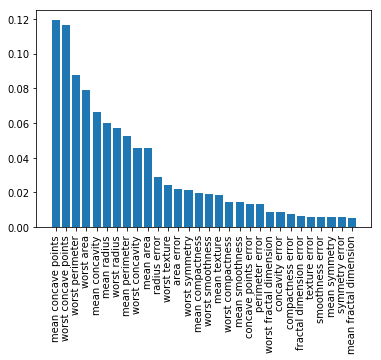

In [95]:
classifier = classifier.fit(cancer.data, cancer.target)
plot_feature_importances(classifier, cancer.feature_names)

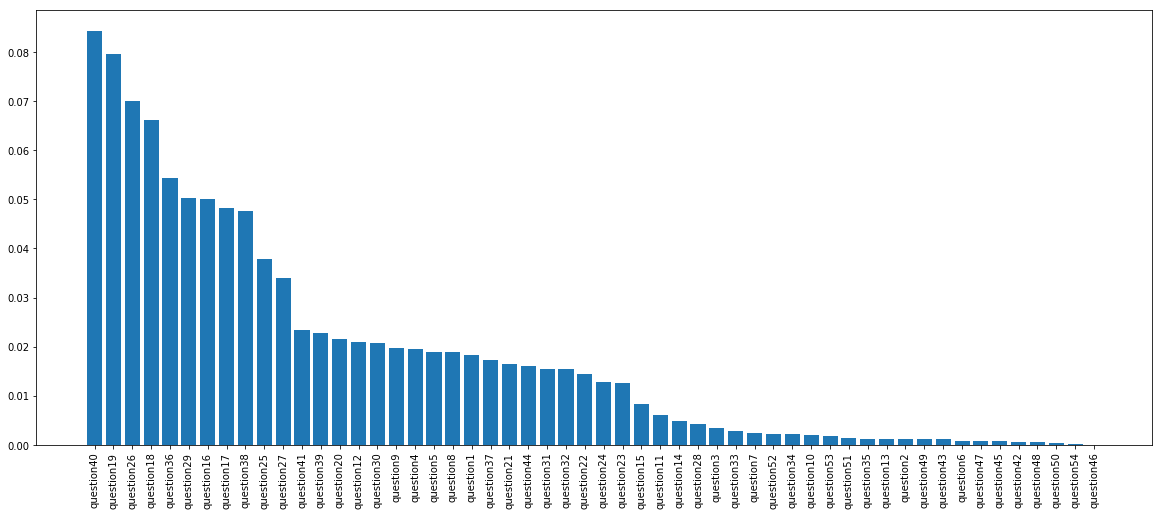

In [96]:
classifier = classifier.fit(divorces['data'], divorces['target'])

# treści pytań są długie, wykres etykietujemy więc samymi ich numerami
labels = np.array(['question' + str(i) for i in range(1, len(divorces['feature_names']) + 1)])
plot_feature_importances(classifier, labels, size=(20, 8))

## Macierz kowariancji

### Wariancja

**Wariancja** jest intuicyjnie utożsamiana ze zróżnicowaniem zbiorowości;
jest średnią arytmetyczną kwadratów różnic poszczególnych wartości cechy od wartości oczekiwanej.
Wariancję zmiennej losowej X oznaczamy jako:

\begin{align}
Var(X)\newline
D^2(X)
\end{align}

I obliczamy za pomocą wzoru:

\begin{align}
D^2(X) = E(X^2) - [E(X)]^2
\end{align}

Gdzie E[X] jest wartością oczekiwaną zmiennej losowej X.

### Kowariancja

**Kowariancją** nazywamy zależnośc liniową między dwowa zmiennymi losowymi X i Y.
Kowariancję oznaczamy jako:

\begin{align}
cov(X,Y)
\end{align}

I wyliczamy ze wzoru:

\begin{align}
cov(X,Y) = E(X * Y) - E(X) * E(Y)
\end{align}

### Macierz kowariancji

#### 1. Sposób wyliczania
**Macierz kowariancji** jest uogólnieniem pojęcia wariancji dla przypadków wielowymiarowych. Dla wektora losowego

\begin{align}
(X_1,X_2,...,X_n)
\end{align}

Ma ona postać:

\begin{equation*}
\Sigma =  \begin{vmatrix}
\ \sigma^2_1 & \sigma_{12} & ... & \sigma_{1n}  \\
\ \sigma_{21} & \sigma^2_2 & ... & \sigma_{2n}  \\
\ ... & ... & ... & ... \\
\ \sigma_{n1} & \sigma_{n2} & ... & \sigma^2_n
\end{vmatrix}
\end{equation*}

Gdzie:

\begin{align}
\sigma^2_i = D^2(X_i) - wariancja\; zmiennej\; X_i \\
\end{align}

\begin{align}
\sigma_{ij} = cov(X_i, X_j) - kowariancja\; między\; zmiennymi\; losowymi\; X_i\; i\; X_j
\end{align}

#### 2. Macierz kowariancji w Pythonie

Do wyznaczania macierzy kowariancji używamy funkcji cov z biblioteki numpy. Wylicza ona macierz na podstawie podanych tablic i wag.

<center>numpy.cov(m, y=None, rowvar=True, bias=False, ddof=None, fweights=None, aweights=None)</center>

gdzie najważniejsze argumenty to:
<ul>
    <li> m - jedno- lub dwu- wymiarowa tablic danych, zawiarająca różne zmienne i obserwacje</li>
    <li>bias - odpowiada za rodzaj normalizacji</li>
    <li>fweights - jednowymiarowa tablica liczb całkowitych, wyznaczająca wagi częstotliwości, czyli ile razy dana obserwacja powinna być powtórzona</li>
    <li>aweights - jednowymiarowa tablica, odpowiedzialna za wagi ("ważność") danych obserwacji.</li>
</ul>

#### 3. Działanie funkcji numpy.cov

Mamy daną tablicę m, gdzie kolumny są poszeczególnymi obserwacjami, niech f = fweight i a = aweight. Wyliczanie macierzy kowariancji następuje w podany sposób:

=> w = f * a<br>
=> v1 = np.sum(w)<br>
=> v2 = np.sum(w * a)<br>
=> m -= np.sum(m * w, axis=1, keepdims=True) / v1<br>
=> cov = np.dot(m * w, m.T) * v1 / (v1**2 - ddof * v2)<br>

In [ ]:
cancer.data[0:3,0:3]

In [ ]:
np.cov(cancer.data[0:3,0:3])

In [ ]:
cancer.data

In [ ]:
cov_matrix = np.cov(cancer.data)

In [ ]:
cov_matrix

### Heat map

**Heat mapa** jest graficzną reprezentacją danych, gdzie każdy wartość elementu macierzy jest reprezentowana przez dany kolor.

<img src="heat_map.png">

In [23]:
import seaborn as sns

In [24]:
matrix_data = np.cov(divorces['data'])

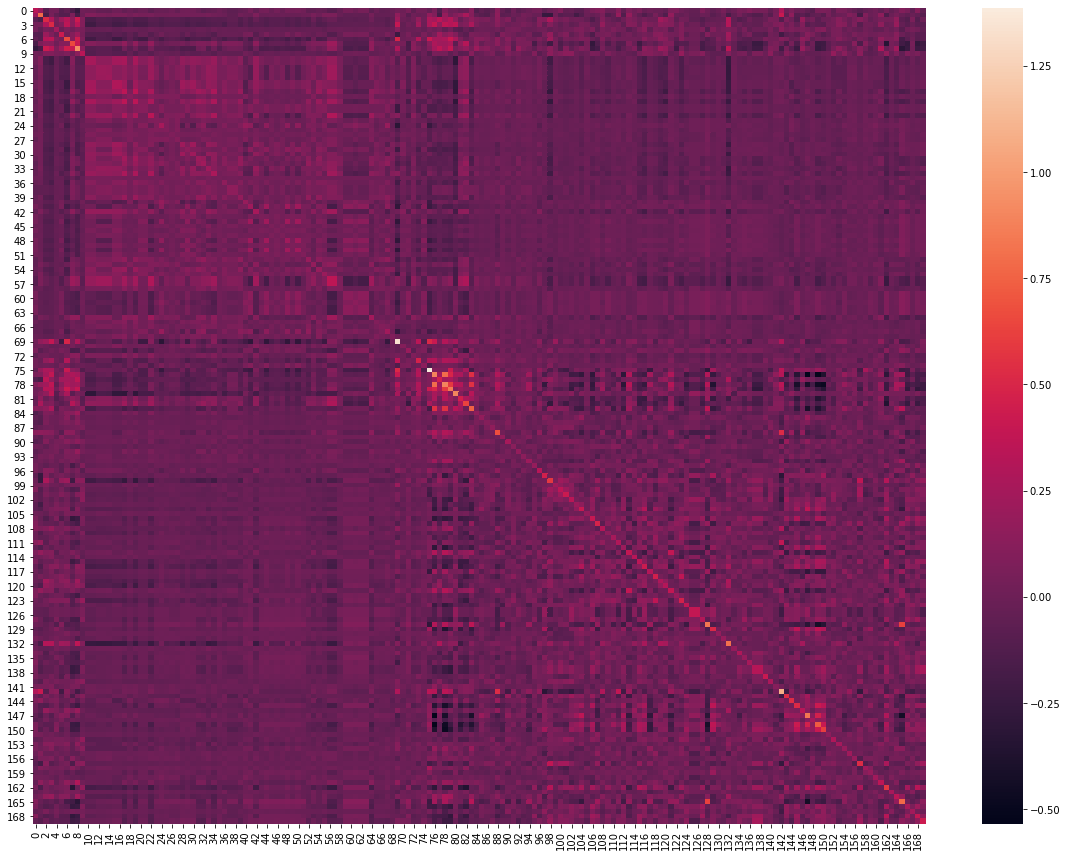

In [25]:
plt.subplots(figsize=(20,15))
sns.heatmap(matrix_data )

Heat mapy pozwalają na łatwiejsze znalezienie obszarów o większym znaczeniu w przypadku dużej ilości danych. Są one łatwiejsze do przeanalizowania niż surowe dane liczbowe.

Z takiej heat mapy możemy odczytać jak dużą kowariancją cechują się dwie zmienne losowe. Duża kowariancja między dwiema zmiennymi wskazuje, że są one wysoce „skorelowane” - zawierają informacje, które można przewidzieć lub przedstawić pojedynczą zmienną.

Klasyfikowanie dużych danych bywa czasochłonne i zasobożerne. Informacje, które można wywnioskować z heat mapy pozwalają nam wyłonić z pełnego zbioru danych odpowiedni fragment, który następnie posłuży do tworzenia bardziej optymalnych klasyfikatorów.

## Transformacja PCA

Transformacja PCA (Principal Component Analysis) jest algorytmem analizy danych. Wykorzystuje informacje o powiązaniach pomiędzy danymi wejściowymi. Umożliwia to dokonanie selekcji i "kompresji" danych bez utraty istotnych informacji pierwotnego zestawu danych. PCA może być wykorzystane właśnie w problemach kompresji, analizy oraz przetwarzania złożonych zbiorów danych tak, aby wyłuszczyć z nich składaniki o największej zmienności i największym wpływie na pozostałe informacje.

Transfomacja PCA jest przekształceniem liniowym Y = W * X, gdzie Y - macierz przestrzeni wyjściowe, która zachowuje najistotniejsze informacje danych wejściowych X, a W jest macierzą przekształceń PCA.

### Sposób wyliczania

Podobnie jak w przypadku macierzy kowariancji, danymi wejściowymi jest macierz X, w której każdy wiersz to jedna obserwacja. Wielkość takiej macierzy to N x P (gdzie N - wielkość wektora danych, a  P - ilość obserwacji).

Dla tak przygotowanych danych należy wyznaczyć macierz autokorelacji.

\begin{align}
R_{xx} = \frac{1}{P} XX^T
\end{align}

Macierz Rxx posiada wymiary N × N. Informuje nas ona w jakim stopniu dane są skorelowane. Koeljnym krokiem algorytmu jest wyznaczenie wartości własnych macierzy Rxx oraz odpowiadających im wektorów własnych. Wartości te, wraz z odpowiadającymi im wektorami własnymi należy uszeregować malejąco. W ten sposób uzyskuje się macierz diagonalną:

\begin{equation*}
D =  \begin{vmatrix}
\ \lambda_1 & 0 & ... & 0  \\
\ 0 & \lambda_2 & ... & 0  \\
\ ... & ... & ... & ... \\
\ 0 & 0 & ... & \lambda_N
\end{vmatrix}
\end{equation*}

Gdzie:

\begin{align}
\lambda_1 > \lambda_2 > .. > \lambda_N
\end{align}

to wartości własne. Macierzy odpowiada macierz wektorów własnych:

\begin{align}
V = [v_1, v_2, ..., v_N]
\end{align}

Istotnym krokiem transformacji jest ocena ile najistotniejszych czynników należy uwzględnić w przekształceniu. W tym celu należy wybrać pierwszy K największych wartości własnych macierzy D, odstających znacząco od pozostałych. W ten sposób otzywamujemy macierz przekształcenia uwzględniającą K znaczących wektorów własnych:

\begin{align}
W = [v_1, v_2, ..., v_K]
\end{align}

Finalnie, przekształcenie PCA danych wejściowych X przedstawia się jako przekształcenie liniowe wspomniane wcześniej:

\begin{align}
Y = WX
\end{align}

### Transformacja PCA w Pythonie

Do wyznaczania transformacji PCA używamy klasy PCA z sklearn.decomposition.

<center>sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)</center>

gdzie najważniejszy argument to n_components - ilość elemetów, które chcemy zachować w transformacji.

Klasa ta posiada m.in. pola:

<ul>
    TODO
</ul>

In [26]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)